In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from utils.misc import fix_random_seed
fix_random_seed(2)

In [3]:
import numpy as np
from torch.utils.data import DataLoader

from utils import datasets as dsets

stage = 1
trn_split = 'va'
attr_availability = 'yes'
worst_metric = 'wga_val'
subsample_type = 'group'
dataset_name = 'Waterbirds'
data_dir = '/scratch/ssd004/scratch/minht/datasets/'
ckpt_path = '/scratch/ssd004/scratch/minht/checkpoints/sd0/Waterbirds/13574640/'

workers = 10
batch_size_train, batch_size_eval = 256, 256


def get_pre_extracted_features(_ckpt_dir: str, _set_name: str) -> np.ndarray:
    pre_extracted_feats = np.load(f'{_ckpt_dir}/feats_{_set_name}.npy', mmap_mode='r')
    pre_extracted_feats = ((pre_extracted_feats - pre_extracted_feats.mean(axis=1, keepdims=True)) /
                           pre_extracted_feats.std(axis=1, keepdims=True))
    return pre_extracted_feats


datasets, dataloaders = dict(), dict()
datasets['val'] = vars(dsets)[dataset_name](data_dir, 'va', None)
datasets['test'] = vars(dsets)[dataset_name](data_dir, 'te', None)
datasets['train_eval'] = vars(dsets)[dataset_name](data_dir, 'tr', None)

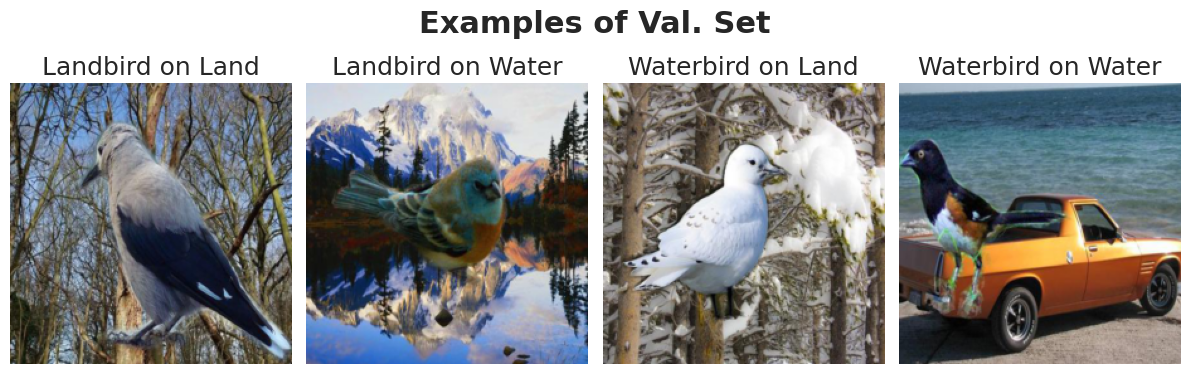

In [4]:
from notebooks.utils_plot import show_examples, plot_distributions
set_name = 'val'
groups_dict = {'00': 'Landbird on Land', '01': 'Landbird on Water', '10': 'Waterbird on Land',
               '11': 'Waterbird on Water'}
show_examples(datasets, groups_dict, set_name)

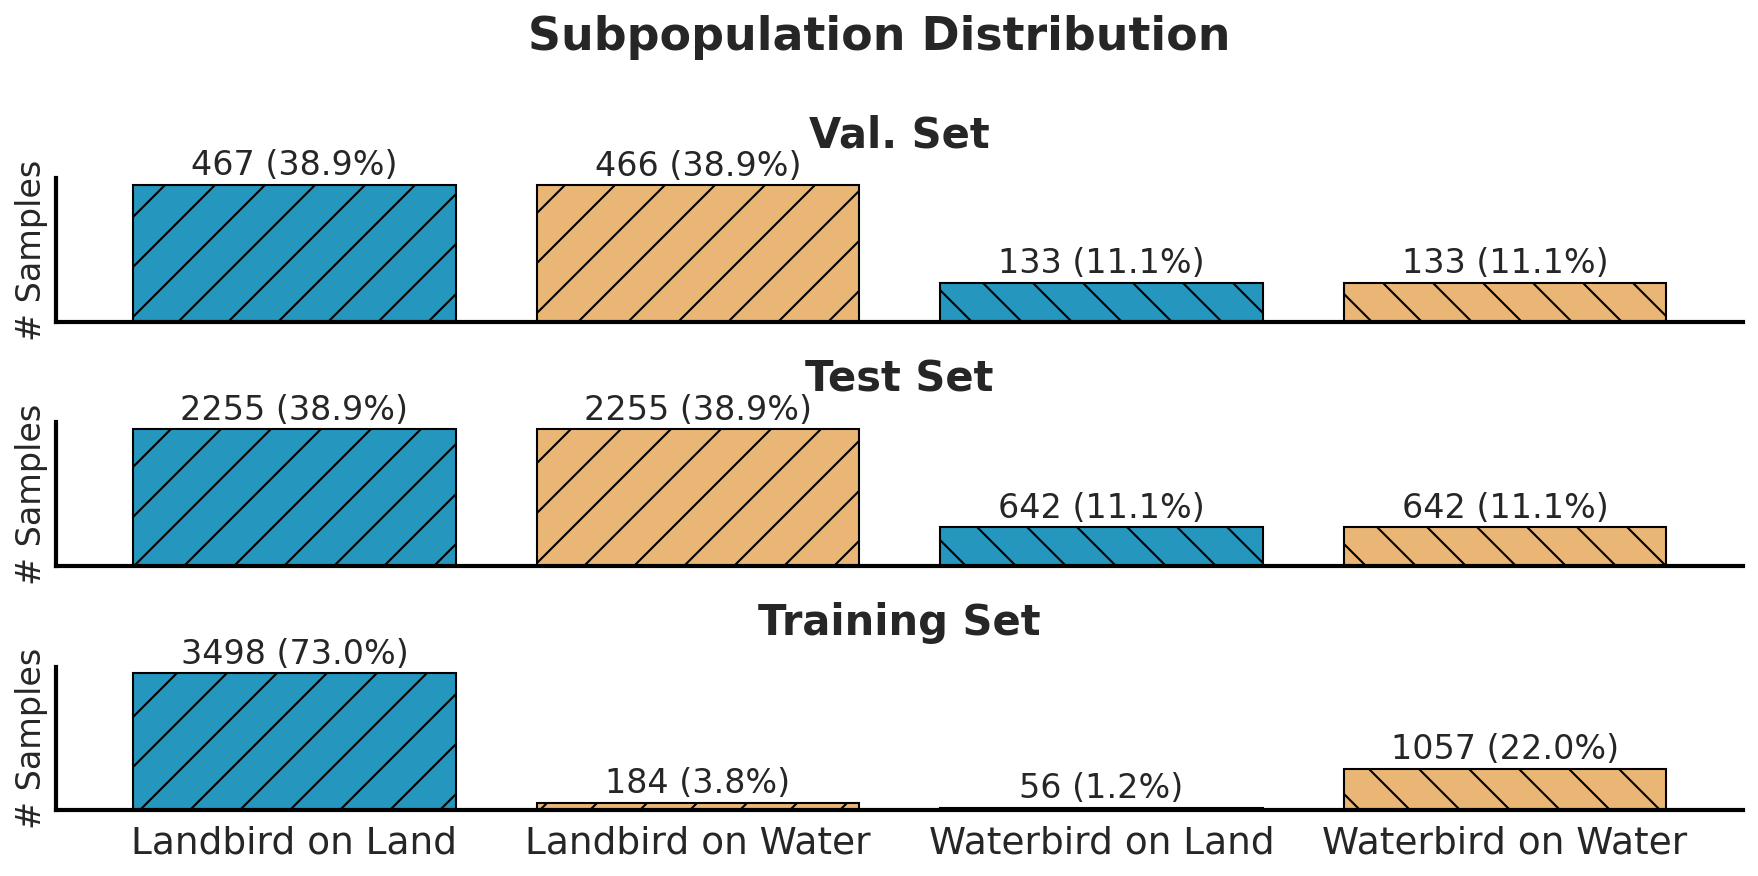

In [5]:
plot_distributions(datasets, groups_dict)

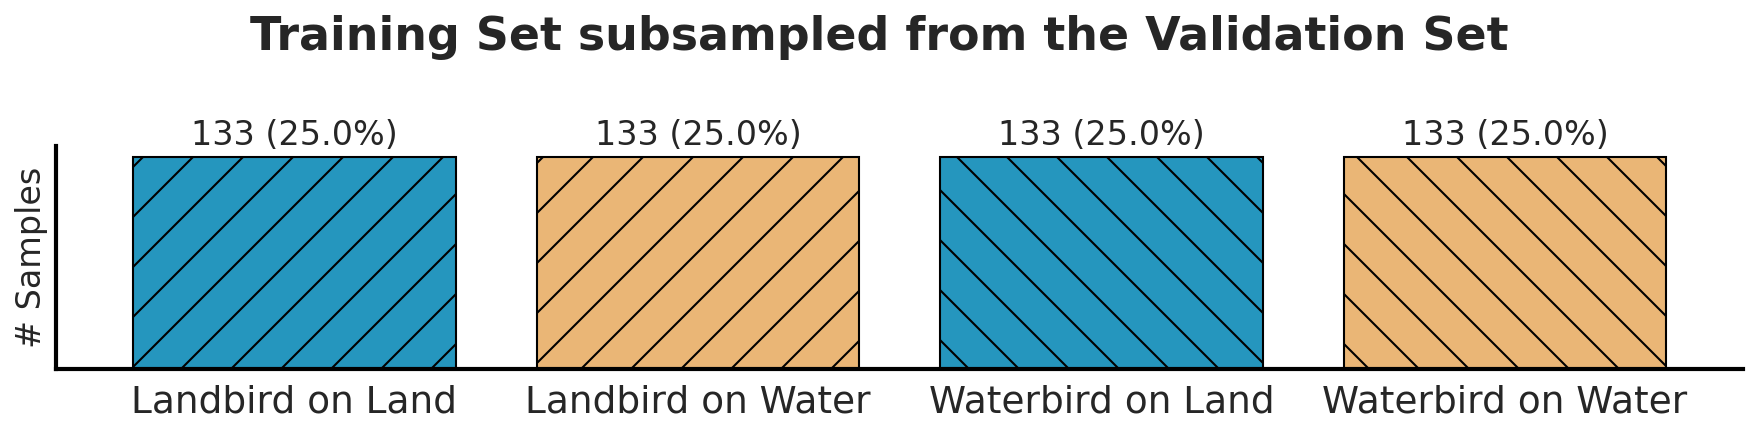

In [6]:
trn_split = 'va'

for set_name in ['val', 'test']:
    datasets[set_name].feats = get_pre_extracted_features(ckpt_path, set_name)
    dataloaders[set_name] = DataLoader(dataset=datasets[set_name], num_workers=workers, pin_memory=False,
                                       batch_size=batch_size_eval, shuffle=False)

def get_subsampled_train_set(_datasets=None, train_attr='yes'):
    if _datasets is None:
        pre_extracted_feats = None
        _datasets = {}
    else:
        pre_extracted_feats = _datasets['val'].feats
    _datasets['train'] = vars(dsets)[dataset_name](
        data_dir, trn_split, None, train_attr=train_attr, subsample_type=subsample_type,
        pre_extracted_feats=pre_extracted_feats)
    return _datasets

def get_train_loader(_datasets, _train_attributes='yes'):
    _datasets = get_subsampled_train_set(_datasets, _train_attributes)
    train_loader = DataLoader(_datasets['train'], batch_size=batch_size_train, drop_last=True, shuffle=True,
                              num_workers=workers, pin_memory=False)
    return train_loader


plot_distributions(get_subsampled_train_set(), groups_dict, fig_size=(12, 3),
                   title='Training Set subsampled from the Validation Set',
                   set_name_dict={'train': ''})

In [7]:
import torch
import torchvision
from torch import nn
from utils.isomaxplus import IsoMaxPlusLossFirstPart

def init_model(_ckpt_path, num_classes=2, _model=None, device='cuda'):
    """The backbone is frozen so we only load it once"""
    if _model is None:
        ckpt = torch.load(_ckpt_path, map_location="cpu")
        _model = torchvision.models.resnet50()
        backbone = torch.nn.Sequential(*list(_model.children())[:-1])
        emb_dim = _model.fc.in_features
        head = IsoMaxPlusLossFirstPart(emb_dim, num_classes)

        _model = nn.Sequential(backbone, nn.Flatten(), head)
        _model.load_state_dict(ckpt, strict=False)
        _model.emb_dim = emb_dim
    else:
        assert hasattr(_model, "emb_dim")
        _model[-1] = IsoMaxPlusLossFirstPart(_model.emb_dim, num_classes)
    _model.to(device)
    return _model

In [8]:
from tqdm import tqdm

from utils.eval_helpers import eval_metrics, get_acc


def evaluate_epoch(_model, eval_loader, device='cuda'):
    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)
    _model.eval()
    all_preds = []
    with torch.no_grad():
        for *_, feats in eval_loader:
            feats = feats.to(device)
            outputs = _model[-1](feats)
            all_preds.append(outputs.detach().softmax(1).cpu())
        all_preds = torch.concat(all_preds, dim=0).numpy()
        _res = eval_metrics(all_preds, np.array(classes), np.array(attributes), np.array(groups))
    return _res['min_group']['accuracy']


def evaluate_ensemble(_prototype_ensemble, eval_loader, _model, device='cuda', show_individuals=False, verbose=True):
    dist_scales = [_[1].detach() for _ in _prototype_ensemble]
    clf = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach().transpose(0, 1)
    preds_list = torch.zeros(clf.shape[0], len(eval_loader.dataset), eval_loader.dataset.num_labels)

    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)

    position = 0

    with torch.no_grad():
        for *_, feats in tqdm(eval_loader, leave=False):
            feats = feats.to(device)

            for i, _weight in enumerate(clf):
                _model[-1].prototypes = torch.nn.Parameter(_weight, requires_grad=False)
                _model[-1].distance_scale = nn.Parameter(dist_scales[i], requires_grad=False)
                _model.eval()
                preds_list[i][position:position + feats.shape[0]] = _model[-1](feats.squeeze())
            position += feats.shape[0]

    if show_individuals:
        for i in range(preds_list.shape[0] - 1, -1, -1):
            preds = preds_list[i].softmax(1).argmax(1).numpy()
            get_acc(preds, classes, groups)

    get_acc(preds_list.softmax(2).mean(0).argmax(1).numpy(), classes, groups, verbose=verbose)

    preds = preds_list.softmax(2).mean(0).detach().cpu().numpy()
    _res = eval_metrics(preds, classes, attributes, groups)
    if verbose:
        print(f"Ensemble WGA: {_res['min_group']['accuracy'] * 100:.1f}")
    return _res

In [9]:
from utils.isomaxplus import IsoMaxPlusLossSecondPart


def train_prototypes(train_loader, model, _prototype_ensemble=(),
                     epochs=20, cov_reg=5e5, wd_weight=10, device='cuda', entropic=30, lr=1e-3, _stage=1, verbose=True):
    best_val_wga, val_wga = 0.0, 0.0
    best_val_wga_prototype = None

    criterion = IsoMaxPlusLossSecondPart(entropic_scale=entropic, reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if len(_prototype_ensemble) > 0:
        _prototype_ensemble = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach()

    for epoch in range(epochs):
        model.train()
        running_loss, running_clf, running_cov, running_correct, total = 0.0, 0.0, 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Stage {_stage}] Epoch {epoch + 1}",
                    leave=(epoch == epochs - 1) and verbose)

        for _, _, labels, _, _, feats in pbar:
            feats = feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model[-1](feats)
            clf_loss = criterion(outputs, labels)

            head = model[-1]
            wd = torch.einsum('ijk,ilk->ijl', [head.prototypes[:, None], head.prototypes[:, None]]) * wd_weight
            wd = wd.squeeze().mean()
            loss = clf_loss + wd

            cov_loss = torch.tensor(0.0, device=device)
            if len(_prototype_ensemble) and (cov_reg > 0):
                _prototypes = torch.cat([head.prototypes[:, None], _prototype_ensemble], dim=1)
                n_pro, n_dim = _prototypes.shape[1:]
                cov = torch.einsum('ijk,ilk->ijl', [_prototypes, _prototypes]) / (n_dim - 1)
                cov_loss = torch.abs(cov[:, 0, 1:].sum(1).div(n_pro).mean())
                loss += cov_loss * cov_reg

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct = (preds == labels).sum().item()
            running_loss += loss.item()
            running_clf += clf_loss.item()
            running_cov += cov_loss.item()
            running_correct += correct
            total += labels.size(0)

            pbar.set_postfix({
                'loss': running_loss / (total // labels.size(0)),
                'clf': running_clf / (total // labels.size(0)),
                'cov': running_cov / (total // labels.size(0)),
                'acc': f"{running_correct / total:.2%}",
                'val wga': f"{val_wga:.2%}"
            })

        val_wga = evaluate_epoch(model, dataloaders['val'])
        if val_wga >= best_val_wga:
            best_val_wga = val_wga
            best_val_wga_prototype = [
                model[-1].prototypes[:, None].detach().clone(),
                model[-1].distance_scale.detach().clone()
            ]

    return best_val_wga_prototype

def cov_reg_scheduler_inv(_cov_reg, _num_stages, alpha=0.05):
    scheduler = [_cov_reg / (1 + alpha * _) for _ in range(_num_stages)]
    scheduler = [_cov_reg] + scheduler
    def cov_reg_schedule(_stage):
        _stage = max(_stage, 1)
        return scheduler[_stage - 1]
    return cov_reg_schedule

In [10]:
import pylab as plt
show_cov_scheduler = False
if show_cov_scheduler:
    _cv_scheduler = cov_reg_scheduler_inv(0, 20, 0.05)
    plt.plot([_cv_scheduler(_) for _ in range(1, 20)])

In [11]:
from functools import partial


def train_ensemble(cov_reg=5e5, random_subset=True, num_stages=20, show_freq=10, seed=0):
    fix_random_seed(seed)
    full_model = None
    prototype_ensemble = []
    ensemble_wga, ensemble_acc, ensemble_balanced_acc = [], [], []
    _train_prototypes = partial(train_prototypes, epochs=20, wd_weight=10, device='cuda', entropic=30, lr=1e-3)
    cv_scheduler = cov_reg_scheduler_inv(cov_reg, num_stages)
    train_loader = get_train_loader(datasets, attr_availability)

    for stage in range(1, num_stages + 1):
        verbose = stage % show_freq == 0 or stage == 1 or stage == num_stages + 1
        full_model = init_model(ckpt_path + 'ckpt_last.pt', num_classes=2, _model=full_model)
        prototype_ensemble.append(_train_prototypes(
            train_loader, full_model,
            _prototype_ensemble=prototype_ensemble, _stage=stage, verbose=verbose,
            cov_reg=cv_scheduler(stage),
        ))
        res = evaluate_ensemble(prototype_ensemble, dataloaders['test'], full_model, device='cuda', verbose=verbose)
        ensemble_wga.append(res['min_group']['accuracy'])
        ensemble_acc.append(res['overall']['accuracy'])
        ensemble_balanced_acc.append(res['overall']['balanced_acc'])

        if stage <= num_stages + 1 and random_subset:
            train_loader = get_train_loader(datasets, attr_availability)
    return ensemble_wga, ensemble_wga


metrics = {'DPE': train_ensemble(cov_reg=5e5, random_subset=True)}

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 10] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, loss=0.199, clf=0.0813, cov=2.04e-7, acc=98.44%, val wga=90.34%]


Avg ACC: 0.959
ACC per group: [0.978, 0.946, 0.945, 0.956]
Ensemble WGA: 94.5


[Stage 20] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, loss=0.19, clf=0.0733, cov=2.61e-7, acc=98.83%, val wga=86.91%]  


Avg ACC: 0.962
ACC per group: [0.985, 0.945, 0.941, 0.96]
Ensemble WGA: 94.1


In [12]:
metrics['Random subset'] = train_ensemble(cov_reg=0, random_subset=True)

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.81it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 10] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s, loss=0.101, clf=0.0404, cov=0, acc=98.83%, val wga=93.35%] 


Avg ACC: 0.963
ACC per group: [0.985, 0.959, 0.925, 0.939]
Ensemble WGA: 92.5


[Stage 20] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, loss=0.109, clf=0.0427, cov=0, acc=98.44%, val wga=93.56%] 


Avg ACC: 0.962
ACC per group: [0.981, 0.957, 0.933, 0.942]
Ensemble WGA: 93.3


In [13]:
metrics['No diversification'] = train_ensemble(cov_reg=0, random_subset=False)

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 10] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, loss=0.0981, clf=0.0368, cov=0, acc=98.63%, val wga=94.42%]


Avg ACC: 0.961
ACC per group: [0.98, 0.959, 0.927, 0.939]
Ensemble WGA: 92.7


[Stage 20] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s, loss=0.1, clf=0.0406, cov=0, acc=98.83%, val wga=95.06%]   


Avg ACC: 0.959
ACC per group: [0.976, 0.957, 0.922, 0.942]
Ensemble WGA: 92.2


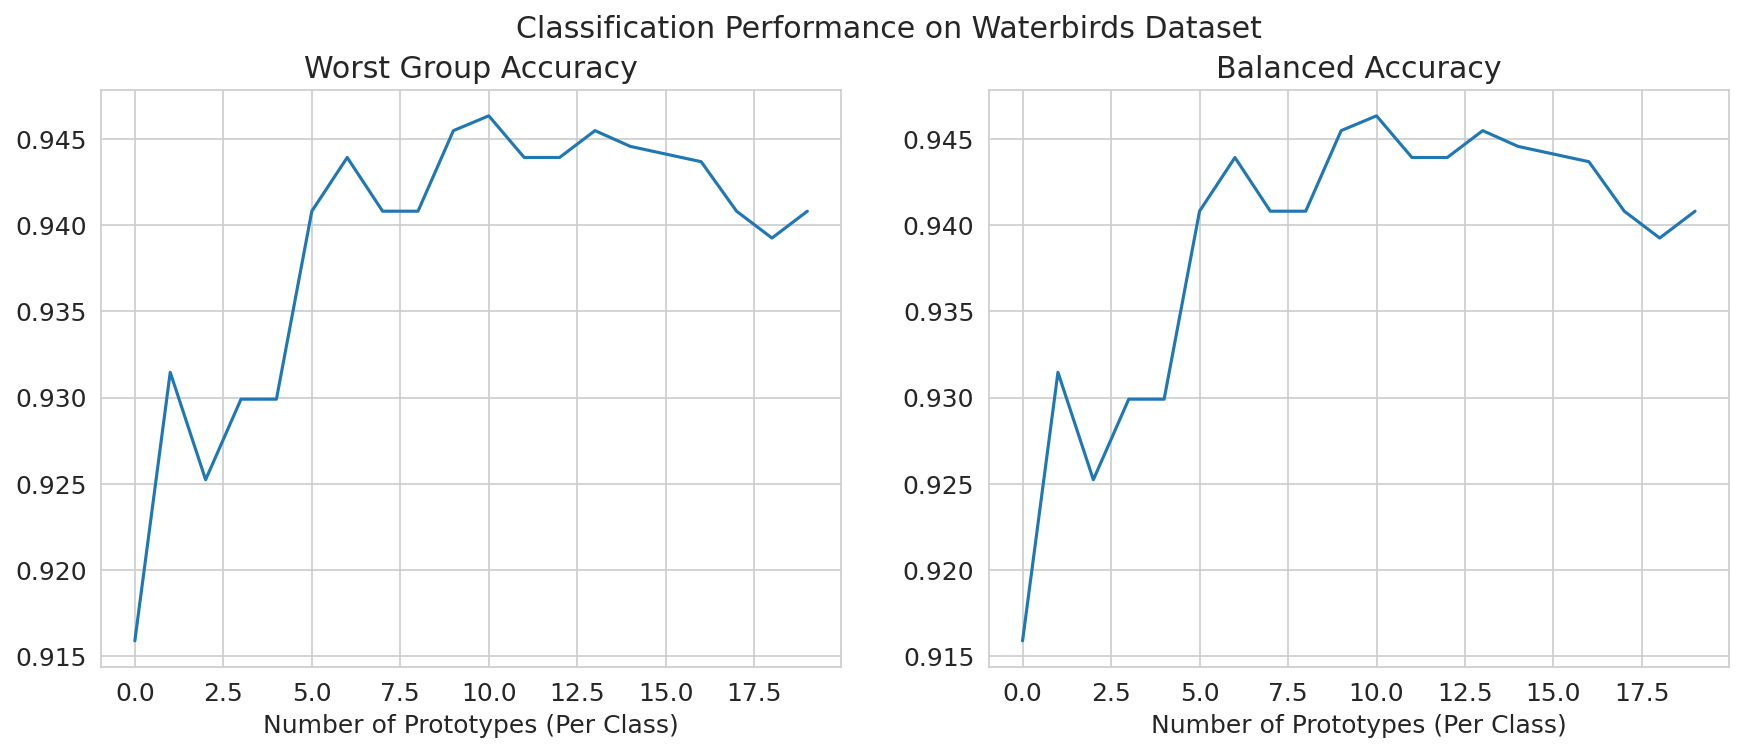

In [14]:
import pylab as plt
plt.rcParams.update({'font.size': 12})

import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
_ = sns.lineplot(metrics['DPE'][0], ax=axes[0])
axes[0].set_title('Worst Group Accuracy')
axes[0].set_xlabel('Number of Prototypes (Per Class)')
_ = sns.lineplot(metrics['DPE'][1], ax=axes[1])
axes[1].set_title('Balanced Accuracy')
plt.suptitle('Classification Performance on Waterbirds Dataset')
_ = axes[1].set_xlabel('Number of Prototypes (Per Class)')